<a href="https://colab.research.google.com/github/Raahim58/Neural-networks/blob/main/02_makemore_part1_bigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Building Makemore from scratch (Part1: bigrams)

* Makemore makes more of the things you give it.
* makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.
* it is basically a bigram character-level language model

**Resources:**
* makemore github repo: https://github.com/karpathy/makemore/tree/master

* tutorial lecture 2 (makemore part 1) code: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb

* makemore pre defined code: https://github.com/karpathy/makemore/blob/master/makemore.py

* link to youtube lecture: https://youtu.be/PaCmpygFfXo?si=Na9cYzwiN-W-Hpfb

* whole lecture series code: https://github.com/karpathy/nn-zero-to-hero

## 1. Exploring the dataset and bigrams

In [ ]:
!wget https://github.com/karpathy/makemore/raw/master/names.txt

--2024-08-20 09:11:18--  https://github.com/karpathy/makemore/raw/master/names.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karpathy/makemore/master/names.txt [following]
--2024-08-20 09:11:18--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.06s   

2024-08-20 09:11:18 (3.95 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()

In [ ]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
len(words)

32033

In [ ]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

* in bigram we are always working with 2 characters at a time
* we are only looking at 1 character which we are given, and we're trying to predict the next character in the sequence.
  * it is a very weak LLM as it only checks the previous character to predict the next character when it can refer to other information to predict -> great place to start
* `zip` takes 2 iterators and it pairs them up, and then it creates an iterator over the tuples of the consecutive entries.
  * if any of these lists are shorter than the other, it will just halt and return.
* `<S>` = special start character -> gets the start character; `<E>` = special end character of the word -> gets the end character of the word

In [ ]:
for w in words[:3]:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [ ]:
list(w)

['a', 'v', 'a']

## 2. Counting bigrams



### 2.1 Python dictionary

In order to learn the statistics of which character is likely to follow the other characters, the simplest way in the bigram language models is to do it by counting.
  * basically we will count how often any one of these combinations occur in the training set, in these words -> hence we will need a dictionary to maintain the counts for each of these bigrams.
  * bigram is a tuple of character 1 and character 2.
* `b.get(bigram)` same as `b[bigram]`, in case `bigram` is not in the dictionary, we would like to return 0 by default -> will basically count and add up how many times the bigram occurs.
* `sorted(b.items(), key = lambda kv: -kv[1])` -> by default sort is on the first item of a tuple, but we want to sort by the values which are the second item of the tuple that is the key value; sorted by the most likely bigrams

In [ ]:
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2) # tuple
    b[bigram] = b.get(bigram, 0) + 1 # `b.get(bigram)` same as `b[bigram]`, in case `bigram` is not in the dictionary, we would like to return 0 by default

In [ ]:
sorted(b.items(), key = lambda kv: -kv[1]) # returns the tuple of key values (values are the counts here)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

### 2.2 In a 2D torch tensor ("training the model")

* rows first character of the bigram, and columns the second character of the bigram
  * each entry in this 2D array will tell us how often the second character follows the first character in the dataset -> library from PyTorch
* tensors allow us to easily manipulate the entries
* we need a 28x28 array where there are 26 alphabets and 2 special characters
  * we will index into an array using integers, so we need a lookup table to look from characters to integers
* `set(''.join(words))` makes one string to join all words in the text file into set which contains no duplicates (sets can't)
* `enumerate` basically gives an iterator over the integer index and the actual element of the list, and then we're mapping the character to the integer

In [ ]:
import torch

In [ ]:
N = torch.zeros((28, 28), dtype=torch.int32) # 3 rows, 5 columns, int32 for count entry

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # stoi = string to integer (a = 0, z = 25)
stoi['<S>'] = 26
stoi['<E>'] = 27

In [ ]:

for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1 # everything starts at zero

In [ ]:
itos = {i:s for s,i in stoi.items()} # itos = integer to string


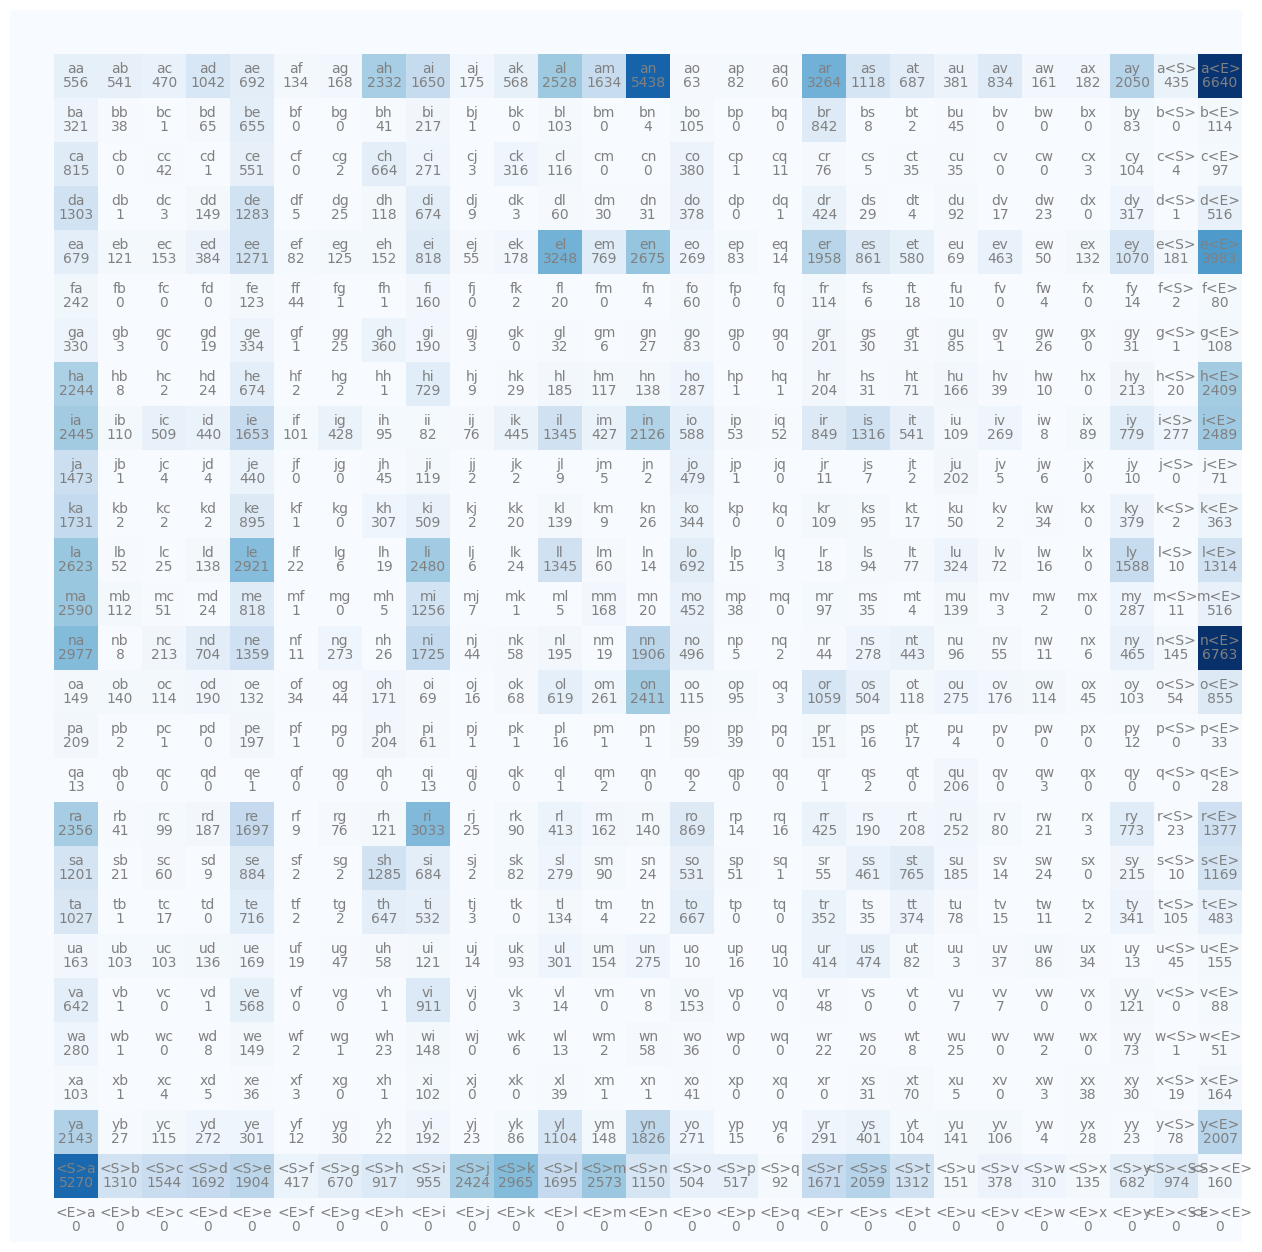

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(1, 28):
    for j in range(1, 28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray') # item is used to pop out the integer
plt.axis('off');

* there is a column and row of zeros because `<S>` will never be the second element of the bigram, as it is always the starting character
  * null-zero: no letters in the word (an empty word) -> `<S>` follows `<E>`
  * we are wasting space with the special characters getting very crowded

### 2.3 Deleting the spurious (S) and (E) tokens in favour of a single . token

In [ ]:
N = torch.zeros((27, 27), dtype=torch.int32) # 3 rows, 5 columns, int32 for count entry

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # stoi = string to integer (a = 0, z = 25)
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # itos = integer to string


In [ ]:
# itos

In [ ]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1 # everything starts at zero

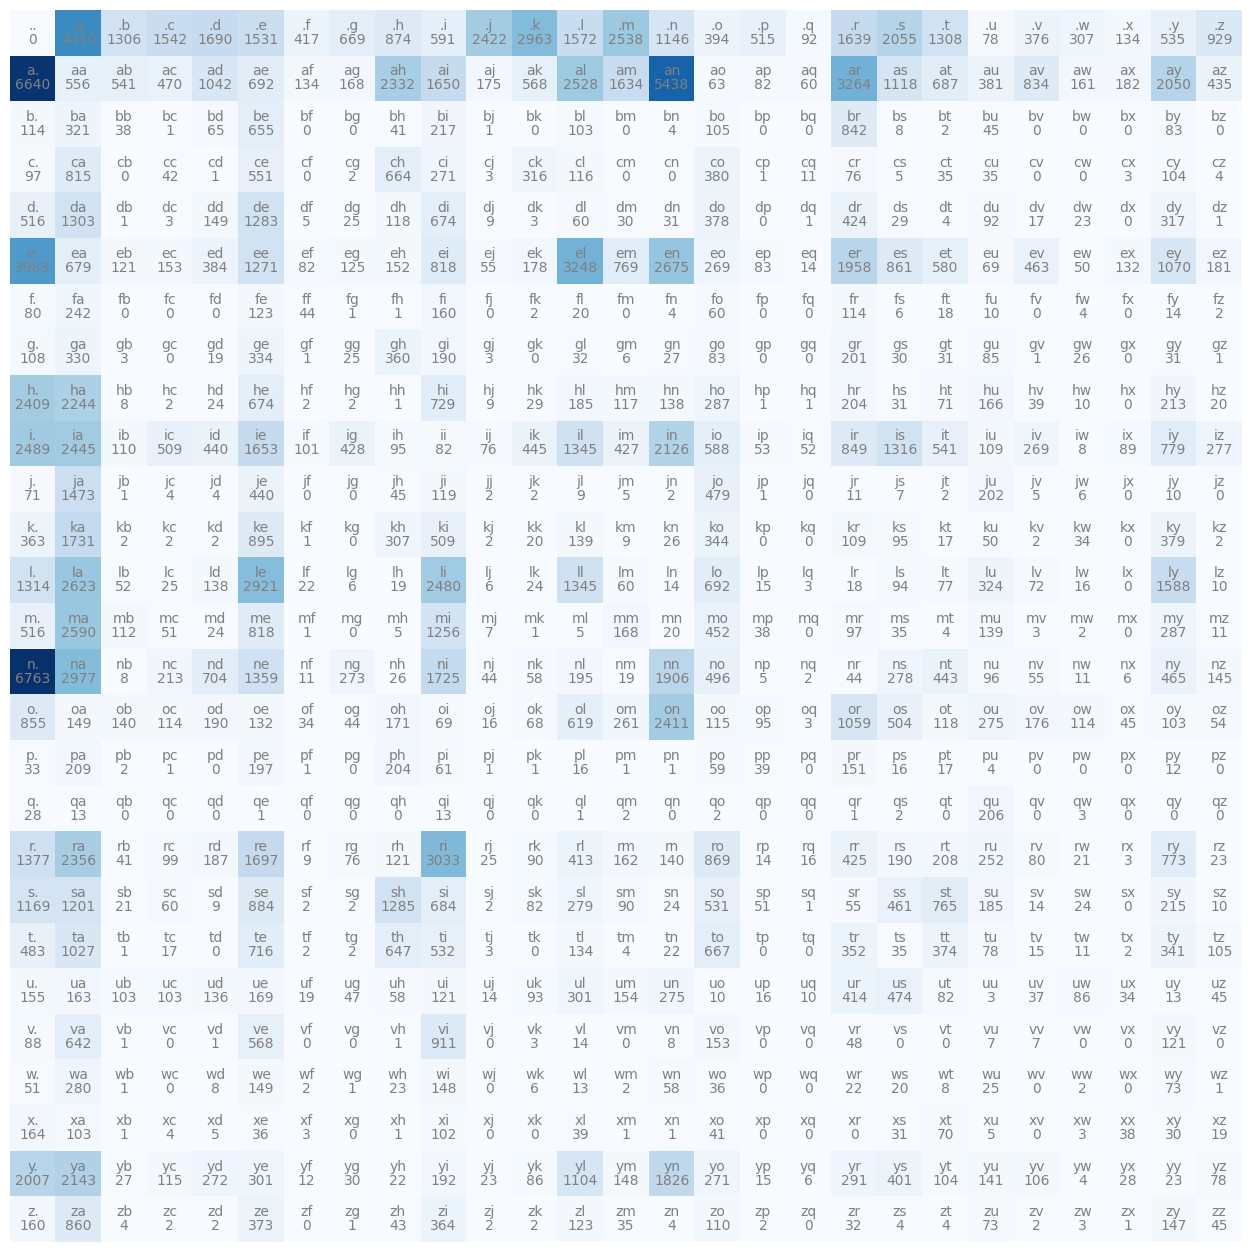

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(0, 27):
    for j in range(0, 27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray') # item is used to pop out the integer
plt.axis('off');

## 3. Sampling from the model

* start from the `<.>`
* have to convert these values to probabilites to sample
* we're about to normalize the counts so we first turn them into floats where the the normalization makes the tensor into one
* we run it through a generator object for reproducbility or deterministic results
* `torch.multinomial` to draw samples from it.

In [ ]:
N[0, :] # first row -> N[0] works too

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [ ]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [ ]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
itos[ix]

'j'

In [ ]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

* 60% of the samples will be 0, 30% will be 1, 10% will be 2.

In [ ]:
torch.multinomial(p, num_samples = 100, replacement = True, generator = g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [ ]:
p.shape

torch.Size([3])

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20): # generate 20 words
  out = []
  ix = 0
  while True:
    p = N[ix].float() # grab the current row
    p = p / p.sum() # normalize the sum to 1
    # p = torch.ones(27) / 27.0 # uniform distribution
    ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item() # what index is next
    out.append(itos[ix])
    if ix == 0:
      break # end token
  print(''.join(out))


junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


* the bigram model doesn't know that `a` for example is the first `a`, all it knows is that `a` is occuring previously, and how likely is it to be last character, it doesn't know if there were other things before it or if there weren't other things before it -> that's why it generates nonsense names.
* this is from a model that is completely untrained.

### 3.1 Improving efficiency through vectorized normalization of the rows

* we keep on normalizing the rows again and again and that is extremly inefficient
* we will prepare a matrix capital `E` that will just have the probabilites in it, so essentially it will be the same matrix `N` of counts, but every single row will have the row of probabilites that is normalized to one
  * we also need to be able to broadcast tensors, or manipulate them
  * `keepdims` adds a dimension
* broadcasting semantics: https://pytorch.org/docs/stable/notes/broadcasting.html

can we divide a tensor of shape [27, 27] by [27, 1] -> can be determined by broadcasting rules, conditions:
  * each tensor is atleast one dimension
  * when iterating over the dimension sizes, starting at the trailing dimension, the dimensions sizes mus either be equal, one of them is 1, or one of them does not exist.
  * we need to align the 2 arrays and their shapes, easy as they have 2 elements
  * in our case, it takes this column vector which is [27, 1], and it copies it 27 times to make these both be 27x27, and then it does an element wise division, because these counts we want to divide by them on every single column
  * if we don't add `keepdims` it will be buggy by removing a batch dimension. The reason for this is that when it is dimensionless with `keepdims = False`:
  ```
  27, 27
    , 27
  ```
  it transforms to:
  ```
  27, 27
   1, 27
  ```
  which is a row vector, and now the division will be [27, 27]/[1,27], and torch in replicating this will take this row vector and will copy it vertically 27 times, dividing element wise -> we are normalizing the columns instead of the rows
    * the issue arises from the silent addition of the dimension as in broadcasting you go from right to left, and if a dimension doensn't exist, it will create one
    * broadcasting makes this vector of 27 a row vector, replicating it vertically and every single point we are dividing by the count in the opposite direction
    * **BROADCASTING IS VERY IMPORTANT TO BE RECHECKED, IT HAS SUBTLE BUGS WHERE DIMENSIONS CAN BE ADDED AND RUIN YOUR OUTPUT**
    * use `/=` to make it efficient and save space -> speed up operations.

In [ ]:
P = N.float()
P /= P.sum(1, keepdims=True) # normalize the rows independently, `keepdims` adds a dimension

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item() # what index is next
    out.append(itos[ix])
    if ix == 0:
      break # end token
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


## 4. Loss function (negative log likelihood of the data under our model)

* GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
  * equivalent to maximizing the log likelihood (because log is monotonic)
  * equivalent to minimizing the negative log likelihood
  * equivalent to minimizing the average negative log likelihood

* log(a*b*c) = log(a) + log(b) + log(c)
* we want to evaluate the quality of this model -> summarise the quality of this model into a single number -> how good is it at predicting our training set: `train_loss`
* first we look at the probabilites each of the bigrams are assigned in the dataset by the model
  * anything about 4% means we have learned something useful as equally like would result in: 1/27 ~ 4%
  * how to summarise all these probabilites into a single number?
  * likelihood refers to the product of all these probabilities which tells us about the probability of the whole dataset assigned by the model we've ruined so a measure of quality
    * log likelihood is just the sum of the logs of the individual probabilities
    * log likelihood max value can be 0 which occurs when all the probabilites are 1, and when the probabilties are lower, the log likelihood will grow more and more negative -> bad
      * loss has the semantic that low is good so we need `neg_log_likelihood` for that case where the minimum value can be 0, and the higher you get, the worse your predictions are.
      * finally loss = `normalized negative log likelihood` where the lower it is, the better.
  * the job of our training is to find parameters which minimize
  the negative log likelihood loss
  * we can evaluate a single word as well


In [ ]:
log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'Log likelihood: {log_likelihood=}')
nll = -log_likelihood
print(f'Negative log likelihood: {nll=}')
print(f'Normalized negative log likelihood: {nll/n}')

Log likelihood: log_likelihood=tensor(-559891.7500)
Negative log likelihood: nll=tensor(559891.7500)
Normalized negative log likelihood: 2.454094171524048


### 4.1 Model smoothing to avoid inf likelihood

* we will add some fake counts, imagine adding a count to 1 to everything and then recalculate the probabilites
  * the more counts you add, the smoother model you're gonna have; the less counts you add, the more peaked model you're gonna have.
  * this will ensure there are no 0's in are probability matrix `p`.

In [ ]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item() # what index is next
    out.append(itos[ix])
    if ix == 0:
      break # end token
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


* prints 'jq` with a probability of 0.0003 instead of 0 before, which stops inf

In [ ]:
log_likelihood = 0.0
n = 0
for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'Log likelihood: {log_likelihood=}')
nll = -log_likelihood
print(f'Negative log likelihood: {nll=}')
print(f'Normalized negative log likelihood: {nll/n}')

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
Log likelihood: log_likelihood=tensor(-27.8672)
Negative log likelihood: nll=tensor(27.8672)
Normalized negative log likelihood: 3.4834020137786865


## 5. Neural network approach

* neural network is going to be a birgram language model: it receives a single character as an input, then there is a neural network with some weights or parameters 'w', and it's going to output the probability distribution over the next character in the sequence
  * in addition to that, we'll be able to evaluate any settings of the parameters of the neural net, because we have a loss function (`normalized negative log likelihood`)
  * we're going to look at the probability distribution, and we'll look at its labels which are the identity of the next character in the bigram
    * knowing what second character actually comes in the bigram allows us to then look at how high the probability the model assigns to that character, and then we want the probability to be high which is another way of saying that loss should be low.
* we will use gradient optimization to tune the parameters/weights so the neural nets is correctly predicting the probabilites for the next character.
* xs = inputs, ys = targets/labels

### 5.1 Creating bigram dataset for the neural net

* `torch.tensor` infers the dtype
 (which you can change) automatically while `torch.Tensor` returns a `torch.FloatTensor`.

In [ ]:
# create the training set of bigrams (x, y)
xs, ys = [], [] # integers

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys) # targets

. e
e m
m m
m a
a .


In [ ]:
xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

### 5.2 Feeding integers into a neural net: one-hot encodings

* not as simple as just plugging it in
* we have an integer index of the character which we can't just plug into a neural net
* `torch.nn.functional`: functional includes a functional approach to work on the input data. It means that the functions of the torch. nn. functional module work directly on the input data, without creating an instance of a neural network layer. Also, the functions in this module are stateless.

In [ ]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # feeding in the whole array
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
xenc.shape, xenc.dtype

(torch.Size([5, 27]), torch.float32)

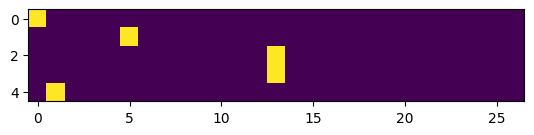

In [ ]:
plt.imshow(xenc);

* every row is an example into the neural net
* appropiate bit is turned on as a 1, and everything else is zero.
* integers converted to vectors and then these vectors can feed into neurons

### 5.3 Creating one linear layer of neurons with matrix multiplication

* neurons (from micrograd) perform a very simple function: w.x + b
* `torch.randn()` gets random numbers from normal distribution, most numbers will be around 0 and a few numbers will be high
  * the weights generated are then multiplied by the inputs
  * what we see out of this operation is we're seeing the 5 activations of this specific neuron on the 5 inputs in the diagram picture above -> evaluated in parallel, we just didn't feed a single input to a single neuron, but we fed simultaneously 5 inputs into the same neuron and in parallel PyTorch calculates (w*x + b), but in the example it is just W with no bias
  * (27,1) indicates the presence of a single neuron, we will use 27 neurons instead -> this will in parallel evaluate all the 27 neurons on all the 5 inputs.
  * for every one of 27 neurons that we created, what is the firing rate of those neurons on every one of those 5 examples.
* using matrix multiplication (@) we can very efficiently evaluate the dot product parallel between lots of input examples in a batch, and a lots of neurons where all those neurons have weights (W) in those columns

In [ ]:
W = torch.randn((27, 27)) # weights of the neuron -> column vector of 27 numbers
xenc @ W # matrix multiplication -> (5, 27) * (27, 27) -> (5, 27)

tensor([[ 2.4082, -0.9310,  1.6533, -1.0398, -0.2789,  0.1865,  0.6555,  0.1053,
         -0.4074,  0.3463,  0.2820,  0.1804, -1.1986, -1.8997, -0.8744, -2.0954,
         -0.5898, -0.0777,  0.8073,  1.0887,  0.8977,  0.7282, -0.5269,  0.3329,
         -0.6588,  0.8104,  0.4800],
        [-0.5025,  0.5783,  1.2525,  0.0653, -2.9542, -0.8405,  0.3400,  1.4426,
         -0.1462,  0.1210, -1.5234, -0.5093,  0.1686,  1.9137,  1.3367, -0.3601,
          0.7165, -1.0486, -1.7917,  1.6282, -0.0178,  0.3653, -1.3742,  1.0981,
          0.4641, -1.4426,  0.7574],
        [ 1.1198,  1.3885, -1.2920,  0.1603,  1.0789,  1.1039, -1.1104, -1.0008,
          0.4718, -0.2980,  1.2025, -0.9950, -1.5343, -3.0010,  0.8271,  1.4970,
         -0.9512, -0.7585, -0.7157,  0.8118,  0.7833, -0.4205, -1.1970,  0.3595,
          0.1979,  1.2948,  0.5867],
        [ 1.1198,  1.3885, -1.2920,  0.1603,  1.0789,  1.1039, -1.1104, -1.0008,
          0.4718, -0.2980,  1.2025, -0.9950, -1.5343, -3.0010,  0.8271,  1.4970

In [ ]:
(xenc @ W.T).shape # matrix multiplication -> (5, 27) * (27, 27)

torch.Size([5, 27])

In [ ]:
(xenc @ W)[3, 13], (xenc[3] * W[:, 13]).sum()

(tensor(-3.0010), tensor(-3.0010))

### 5.4 Transforming neural net outputs into probabilites through `softmax`

* now we have 27 inputs, and 27 neurons
* these neurons perform `w*x`, they don't have a bias and they don't have a null linearity like `tanh`, we won't have any other layers in the neural net as well
* what we are trying to produce is for every input example is we are trying to produce a probability distribution for the next character in the sequence, we have to come up with precise semantics of how we will interpret these 27 numbers that these neurons take on.
* we want the numbers to somehow represent the probabilites of the next character
  * probabilites are positive numbers and they sum to 1, that doesn't just come out of a neural net
  * they can't be counts as they are positive but they are integers only -> counts are not a good thing to ouput from a neural net
  * these 27 numbers are giving us log counts, and to get the counts we are to take log(counts) and then will exponentiate them.
    * exponentials take positive and negative numbers, with negative numbers they just output a number between 0 and 1, and with positive numbers they output numbers greater than 1
  * basically we will take these numbers and interpret them as log counts and then we are going to element wise exponentiate these numbers
    * the neural net is now kindoff predicting the counts (originally found in the probability matrix) which are always positive, and can take on various values depending on the settings of W.
    ```
    logits (log-counts)
    exponentiate logits to get counts which are positive, and equivalent to the N matrix above
    normaize the counts to get the probabilities (sum to 1)
    ```
    * all of these are differentiable operations
    * we are taking inputs, we have differentiable operations which we can back propogate through and we're getting out probability distributions
    * the way we got `'.'` is by first getting its index, then one hot-encoding it, then it went into the neural net and out came a distribution of probabilites -> we will interpret this as the neural nets assignment of how likely every one of these 27 characters are to come next, and as we tune the weights W we are going to be getting different probabilites out for any character we input
    * can we optimize and get W such that the probabilties coming out are pretty good?

In [ ]:
logits = (xenc @ W) # log-counts
counts = logits.exp() # equivalent to the N matrix
probs = counts / counts.sum(1, keepdims=True) # normalized the counts matrix
probs

tensor([[0.2455, 0.0087, 0.1154, 0.0078, 0.0167, 0.0266, 0.0426, 0.0245, 0.0147,
         0.0312, 0.0293, 0.0265, 0.0067, 0.0033, 0.0092, 0.0027, 0.0122, 0.0204,
         0.0495, 0.0656, 0.0542, 0.0458, 0.0130, 0.0308, 0.0114, 0.0497, 0.0357],
        [0.0133, 0.0391, 0.0767, 0.0234, 0.0011, 0.0095, 0.0308, 0.0927, 0.0189,
         0.0247, 0.0048, 0.0132, 0.0259, 0.1485, 0.0834, 0.0153, 0.0448, 0.0077,
         0.0037, 0.1116, 0.0215, 0.0316, 0.0055, 0.0657, 0.0348, 0.0052, 0.0467],
        [0.0711, 0.0931, 0.0064, 0.0272, 0.0683, 0.0700, 0.0076, 0.0085, 0.0372,
         0.0172, 0.0773, 0.0086, 0.0050, 0.0012, 0.0531, 0.1037, 0.0090, 0.0109,
         0.0113, 0.0523, 0.0508, 0.0152, 0.0070, 0.0333, 0.0283, 0.0847, 0.0417],
        [0.0711, 0.0931, 0.0064, 0.0272, 0.0683, 0.0700, 0.0076, 0.0085, 0.0372,
         0.0172, 0.0773, 0.0086, 0.0050, 0.0012, 0.0531, 0.1037, 0.0090, 0.0109,
         0.0113, 0.0523, 0.0508, 0.0152, 0.0070, 0.0333, 0.0283, 0.0847, 0.0417],
        [0.0383, 0.0355,

## Mid-way Summary ------------------------------>>>>

In [ ]:
xs

tensor([ 0,  5, 13, 13,  1])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647) # you can add to the manual seed as well and see if it positively influences the loss
W = torch.randn((27, 27), generator=g)

In [ ]:
# Forward pass (technically)
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding -> becomes an array of [5, 27]
logits = xenc @ W # predict log-counts
counts = logits.exp() # faken counts kinda, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

* all of the above functions are easily backpropogable
* `softmax` basically is a probability output machine taking in positive or negative numbers outputting numbers between 0 and 1, with the matrix of probabilties summing up to 1 as it has been normalized -> basically a normalization function
  * you can put it on top of any other linear layer inside a neural net, making the neural net basically output probabilites which is often very used

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

* the loss function: `nll()` is made up of only differentiable operations, we can minimize the loss by tuning W's/by computing the gradients of the loss w.r.t these W matrices.
* we can then tune W to minimize the loss and find a good setting of W using gradient based optimization
* our neural net is a single linear layer followed by `softmax`.
* in **micrograd**, we had a single number that summarized the performance of the neural net, and everything there was differentiable and was stored in a massive computational graph, and then we iterated all of the parameters making sure the gradients were set to zero, and then we initiated backpropogation by calling `loss.backward()` at the final output node of loss making sure we populated all the parameters.grad, then in the update we iterated over all the parameters and the element of our parameters was nudged in the opposite direction of the gradient -> going to do exact same thing here for **makemore**.

## 6. Optimization

* we want to pluck out the probabilites at the correct indices here in an efficient way -> vectorized form

In [ ]:
probs.shape

torch.Size([5, 27])

In [ ]:
ys

tensor([ 5, 13, 13,  1,  0])

In [ ]:
# These are the probabilites we want in a vectorized form
probs[torch.arange(5), ys]

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150])

In [ ]:
# Calculating loss
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.7693)

* need `requires_grad = True` to calculate backward pass which essentially calculates gradients


In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(loss.item())

3.669245958328247


In [ ]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

* when we did forward pass, PyTorch keeps track of all the operations under the hood, it builds a full computational graph (like in micrograd)
* `loss.backward()` fills the gradients of all the intermediates all the way back to W's which are the parameters of our neural net.
* each element of `W.grad()` is telling us the influence of that weight on the loss function
* we don't need a loop over the update on the parameter like in micrograd, because we have only one parameter

In [ ]:
# W.grad # gradient of the loss function with respect to W

In [ ]:
W.data += -0.1 * W.grad # updates the tensor

### 6.1 Putting it all together

* optimizing over all the bigrams of all the words in the dataset
* first we achieved the loss by counting above, now we achieve it through gradient descent -> getting roughly the same result as we are not really taking in any additional information, we are just taking in a previous character and trying to predict the next one
  * instead of doing it explicitly by counting and normalizing, we are doing through gradient based learning
  * bigram model is very simple so we can afford to explicitly predict the probabilites manually through counting and maintain them in a table
  * the gradient based approach is quite more flexible
    * we can expand this approach and complexify the neural net
    * first we were taking a single character from before, now we'll be taking multiple previous characters and we'll be feeding them into increasingly complex nerual nets
    * fundamentally the output of the model will always be logits, and those logits will always go through the same transformation:
    ```
    softmax -> calculate the loss function -> negative log likelihood -> gradient based optimization
    ```
    * none of this fundamentally change as we complexify our models leading to transformers
    * the only thing that will change is the way we do the forward pass, where we take in multiple previous characters and calculate the logits for the next character in sequence: will become more complex but will use the same machinery to optimize it.
    * keeping counts in a table is an unscalable approach as storing multiple previous characters in a table will be impossible going forward, on the other hand the neural network approach is much more scalable , and is something we can easily improve upon in future.
* we take one-hot and multiple by W,so logits becomes the appropiate row of W -> so W here is essentially same as the one in array in the N matrix table, but W here is not the counts but the **log counts** so more appropaite to say that `W.exp()` resembles the array in the table.
  * the array was filled in by counting and by basically populating the counts of the bigrams, whereas in the gradient based framework we initialize it randomly, and then we let the loss guide us to arrive at the exact same array.
* gradient based framework has something similar to the model smoothing:
  * the W's initialized randomly can also be initialized to 0, if all the entries of W are 0, then all logits become 0, and then exponentiating those logits makes the counts 1, hence the probabilties turn out to be uniform
    * hence incentivising W to be near 0 is basically equivalent to label smoothing, and the more you incentivise that in the loss function, the more smooth distribution you will receive. This brings us to **regularization** where we can augment the loss function to have a small component called **regularization loss**
    * `(W**2).mean()` -> achieve 0 loss if W is 0 otherwise you achive a non-zero loss
      * we have 2 components in optimization, not only does it try to make all the probabilites work out, but in addition to that an additional component is there trying to make the entries near zero. This is like adding a spring force for W to become 0 and for the probabilites to become uniform, but they also simultaneously want to match up the probabilties as indicated by the data.
      * the strength of the regularization (we use 0.01 here) is exactly controlling the counts that we add in model smoothing. **The higher than regularization strength number is, the more it will dominate the other part of the function pushing the loss to 0, making the probabilties uniform so choosing a small number like 0.01 keeps everything in balance.**

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples (total bigrams): ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples (total bigrams):  228146


In [ ]:
# gradient descent
for k in range(10):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

2.4829699993133545
2.4829440116882324
2.482919216156006
2.482893943786621
2.4828693866729736
2.4828450679779053
2.482821226119995
2.482797622680664
2.482774257659912
2.4827513694763184


In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  ix = 0
  while True:

    # ---------- Fundamentally same models:
    # BEFORE:
    # p = P[ix]
    # ----------
    # NOW (neural gradient method):
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

juwjdjdjancqydjufhqyywecnw.
.
oiin.
toziasz.
twt.


## Conclusion



* We've actually covered a lot of ground. We introduced the bigram character level of the model. We saw how we can train the model, how we can sample from the model, and how we can evaluate the quality of the model using the negative model algorithm plus. And then we actually trained the model in two completely different ways that actually gave us the result in the same model. In the first way, we just counted out the frequency of all the items and memorized it.


* In the second way, we used the negative log likelihood loss as a guide to optimizing the counts matrix, or the counts array, so that the loss is minimized in the gradient-based framework. And we saw that both of them get the same result, and that's that. Now the second one is the gradient-based framework is much more flexible. And right now, our neural network is super simple. We're taking a single previous character, and we're taking it through a single linear layer to calculate the logits.

* This is about to complexify. So in the follow-up videos, we're going to be taking more and more of these characters, and we're going to be feeding them into a neural network. But this neural network will still output the exact same thing. The neural network will output logits. And these logits will still be normalized in the exact same way, and all the loss and everything else in the gradient, the gradient is big, everything stays the same. It's just that this neural net will now complexify all the way to the transpose.